<a href="https://colab.research.google.com/github/amanzoni1/qLoRA-FSDP/blob/main/SFT_Gemma_7B_Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Gemma-7B-Instruct for Financial Sentiment Classification

## 🎯 Project Overview

In this comprehensive Colab project, we'll demonstrate **memory-efficient fine-tuning** of a large language model using modern techniques. We'll transform **Gemma-7B-Instruct** from a general-purpose assistant into a specialized financial sentiment classifier through parameter-efficient training.

## 🔧 Technical Stack
- **Base Model**: Gemma-7B-Instruct (7B parameters)
- **Fine-tuning Method**: Supervised Fine-Tuning (SFT) with LoRA adapters
- **Memory Optimization**: 4-bit quantization via bitsandbytes
- **Framework**: Transformers + PEFT + TRL


## 💡 Why Fine-Tune Instead of Zero-Shot?

Large language models like Gemma can do sentiment analysis out-of-the-box, but fine-tuning gives you:

1. **Update + Learn New Knowledge**  
   Inject domain-specific financial terminology and market context that general models might miss—for example:  
   - *“Fed hawkish stance”* → Recognize central bank policy implications  
   - *“Earnings beat by 15%”* → Grasp magnitude significance

2. **Customize Behavior**  
   Enforce consistent, structured outputs:  
   - Turn verbose explanations into clean labels  
   - Standardize optional fields (e.g. confidence scores)  

3. **Optimize for Your Task**  
   Improve accuracy on subtle, finance-specific sentiment cues:  
   - Distinguish market-moving news vs. routine reports  
   - Handle jargon, numbers, and percentages robustly

## 📊 Generative Classification

Instead of traditional classification heads, we frame sentiment analysis as a **generative task**:

```
Input Prompt:
"Analyze the sentiment of this financial headline: 'Apple reports record Q3 revenue, beats analyst expectations by 12%'
Sentiment:"

Expected Output:
{
  "sentiment": "POSITIVE",
  "confidence": 0.87
}
```

This approach leverages the model's natural language generation capabilities while maintaining structure.


## Import Necessary Libraries

Begin by installing and importing all the essential libraries required for data handling, model building, training, evaluation, and visualization. This ensures that all dependencies are met and the environment is set up correctly.



In [1]:
!pip install --quiet datasets pandas matplotlib

In [1]:
!pip install -U datasets

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from wordcloud import WordCloud
from datasets import load_dataset, Dataset
from transformers import AutoTokenizer

In [3]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Dataset Overview

In [4]:
from datasets import load_dataset_builder

ds_builder = load_dataset_builder("takala/financial_phrasebank", "sentences_allagree")

ds_builder.info.description
ds_builder.info.features

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.88k [00:00<?, ?B/s]

financial_phrasebank.py:   0%|          | 0.00/6.04k [00:00<?, ?B/s]

{'sentence': Value(dtype='string', id=None),
 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}

In [25]:
# ============================================================================
# 1. DATASET LOADING
# ============================================================================

dataset = load_dataset("financial_phrasebank", "sentences_allagree")

In [26]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 2264
    })
})

In [27]:
dataset = load_dataset("financial_phrasebank", "sentences_allagree", split="train")

In [31]:
dataset[42]

{'sentence': "In January-September 2007 , Finnlines ' net sales rose to EUR 505.4 mn from EUR 473.5 mn in the corresponding period in 2006 .",
 'label': 2}

In [33]:
dataset[:3]['sentence']

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 "For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .",
 'In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .']

In [34]:
dataset[:3]['label']

[1, 2, 2]

In [7]:
# ============================================================================
# 1. DATASET LOADING
# ============================================================================

def load_financial_phrasebank():
    """
    Load the Financial PhraseBank dataset using HuggingFace datasets library

    Returns:
        datasets.Dataset: Loaded dataset with proper train/validation splits
    """
    try:
        # Try loading from HuggingFace Hub first
        print("🔄 Loading Financial PhraseBank from HuggingFace Hub...")
        dataset = load_dataset("financial_phrasebank", "sentences_allagree")
        print(f"✅ Successfully loaded dataset from HuggingFace Hub")
        return dataset

    except Exception as e:
        print(f"⚠️  Could not load from HuggingFace Hub: {e}")


In [8]:
# ============================================================================
# 2. BASIC DATASET EXPLORATION
# ============================================================================

def explore_dataset_basics(dataset):
    """
    Perform basic exploration of the HuggingFace dataset

    Args:
        dataset: HuggingFace DatasetDict or Dataset
    """
    print("=" * 60)
    print("📊 DATASET OVERVIEW")
    print("=" * 60)

    # Handle both DatasetDict and single Dataset
    if hasattr(dataset, 'keys'):  # DatasetDict
        train_data = dataset['train']
        print(f"Dataset splits: {list(dataset.keys())}")
        print(f"Train size: {len(train_data)}")
        if 'validation' in dataset:
            print(f"Validation size: {len(dataset['validation'])}")
        if 'test' in dataset:
            print(f"Test size: {len(dataset['test'])}")
    else:  # Single Dataset
        train_data = dataset
        print(f"Dataset size: {len(train_data)}")

    print(f"Features: {list(train_data.features.keys())}")

    # Convert to pandas for easier analysis
    df = train_data.to_pandas()

    print("\n" + "=" * 60)
    print("🏷️  SENTIMENT DISTRIBUTION")
    print("=" * 60)

    if 'sentiment' in df.columns:
        sentiment_col = 'sentiment'
    elif 'label' in df.columns:
        # Map numeric labels to text if needed
        if df['label'].dtype in ['int64', 'int32']:
            label_map = {0: 'negative', 1: 'positive', 2: 'neutral'}
            df['sentiment'] = df['label'].map(label_map)
            sentiment_col = 'sentiment'
        else:
            sentiment_col = 'label'

    sentiment_counts = df[sentiment_col].value_counts()
    print(sentiment_counts)

    # Calculate percentages
    sentiment_pct = df[sentiment_col].value_counts(normalize=True) * 100
    print("\nPercentages:")
    for sentiment, pct in sentiment_pct.items():
        print(f"{sentiment}: {pct:.1f}%")

    print("\n" + "=" * 60)
    print("📝 SAMPLE SENTENCES")
    print("=" * 60)

    for sentiment in df[sentiment_col].unique():
        print(f"\n{sentiment.upper()} examples:")
        samples = df[df[sentiment_col] == sentiment]['sentence'].head(3)
        for i, sentence in enumerate(samples, 1):
            print(f"  {i}. {sentence}")

    return df

def plot_sentiment_distribution(df):
    """
    Visualize sentiment distribution
    """
    # Determine sentiment column
    sentiment_col = 'sentiment' if 'sentiment' in df.columns else 'label'

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Bar plot
    sentiment_counts = df[sentiment_col].value_counts()
    bars = ax1.bar(sentiment_counts.index, sentiment_counts.values)
    ax1.set_title('Sentiment Distribution (Count)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Sentiment')
    ax1.set_ylabel('Count')

    # Add count labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 10,
                f'{int(height)}', ha='center', va='bottom')

    # Pie chart
    colors = ['#ff9999', '#66b3ff', '#99ff99']
    wedges, texts, autotexts = ax2.pie(sentiment_counts.values,
                                      labels=sentiment_counts.index,
                                      autopct='%1.1f%%',
                                      colors=colors,
                                      startangle=90)
    ax2.set_title('Sentiment Distribution (Percentage)', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

In [9]:
# ============================================================================
# 3. TEXT ANALYSIS
# ============================================================================

def analyze_text_characteristics(df):
    """
    Analyze text characteristics like length, word count, etc.
    """
    print("=" * 60)
    print("📊 TEXT CHARACTERISTICS ANALYSIS")
    print("=" * 60)

    # Calculate text statistics
    df['char_count'] = df['sentence'].str.len()
    df['word_count'] = df['sentence'].str.split().str.len()
    df['avg_word_length'] = df['sentence'].apply(lambda x: np.mean([len(word) for word in x.split()]))

    # Overall statistics
    print("Overall Statistics:")
    print(f"Average sentence length: {df['char_count'].mean():.1f} characters")
    print(f"Average word count: {df['word_count'].mean():.1f} words")
    print(f"Average word length: {df['avg_word_length'].mean():.1f} characters")

    print("\nLength Distribution by Sentiment:")
    length_by_sentiment = df.groupby('sentiment').agg({
        'char_count': ['mean', 'std'],
        'word_count': ['mean', 'std']
    }).round(2)
    print(length_by_sentiment)

    return df

def plot_text_length_distribution(df):
    """
    Plot text length distributions
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Character count distribution
    for sentiment in df['sentiment'].unique():
        data = df[df['sentiment'] == sentiment]['char_count']
        axes[0,0].hist(data, alpha=0.7, label=sentiment, bins=20)
    axes[0,0].set_title('Character Count Distribution by Sentiment')
    axes[0,0].set_xlabel('Character Count')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()

    # Word count distribution
    for sentiment in df['sentiment'].unique():
        data = df[df['sentiment'] == sentiment]['word_count']
        axes[0,1].hist(data, alpha=0.7, label=sentiment, bins=15)
    axes[0,1].set_title('Word Count Distribution by Sentiment')
    axes[0,1].set_xlabel('Word Count')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].legend()

    # Box plots for character count
    df.boxplot(column='char_count', by='sentiment', ax=axes[1,0])
    axes[1,0].set_title('Character Count by Sentiment (Boxplot)')
    axes[1,0].set_xlabel('Sentiment')

    # Box plots for word count
    df.boxplot(column='word_count', by='sentiment', ax=axes[1,1])
    axes[1,1].set_title('Word Count by Sentiment (Boxplot)')
    axes[1,1].set_xlabel('Sentiment')

    plt.tight_layout()
    plt.show()

In [10]:
# ============================================================================
# 4. VOCABULARY ANALYSIS
# ============================================================================

def analyze_vocabulary(df):
    """
    Analyze vocabulary characteristics
    """
    print("=" * 60)
    print("📚 VOCABULARY ANALYSIS")
    print("=" * 60)

    # Extract all words
    all_words = []
    for sentence in df['sentence']:
        words = re.findall(r'\b\w+\b', sentence.lower())
        all_words.extend(words)

    word_freq = Counter(all_words)

    print(f"Total words: {len(all_words)}")
    print(f"Unique words: {len(word_freq)}")
    print(f"Vocabulary richness: {len(word_freq)/len(all_words):.3f}")

    print("\nMost common words:")
    for word, count in word_freq.most_common(20):
        print(f"  {word}: {count}")

    # Analyze by sentiment
    print("\nTop words by sentiment:")
    for sentiment in df['sentiment'].unique():
        sentiment_text = ' '.join(df[df['sentiment'] == sentiment]['sentence'])
        words = re.findall(r'\b\w+\b', sentiment_text.lower())
        sentiment_freq = Counter(words)

        print(f"\n{sentiment.upper()}:")
        for word, count in sentiment_freq.most_common(10):
            print(f"  {word}: {count}")

def create_word_clouds(df):
    """
    Create word clouds for each sentiment
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, sentiment in enumerate(df['sentiment'].unique()):
        text = ' '.join(df[df['sentiment'] == sentiment]['sentence'])

        wordcloud = WordCloud(width=400, height=300,
                            background_color='white',
                            colormap='viridis').generate(text)

        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].set_title(f'{sentiment.upper()} Word Cloud', fontsize=14, fontweight='bold')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
# ============================================================================
# 5. FINANCIAL TERMS ANALYSIS
# ============================================================================

def analyze_financial_terms(df):
    """
    Analyze financial-specific terminology
    """
    print("=" * 60)
    print("💰 FINANCIAL TERMS ANALYSIS")
    print("=" * 60)

    # Define financial keywords
    financial_terms = [
        'revenue', 'profit', 'loss', 'earnings', 'growth', 'decline',
        'stock', 'share', 'dividend', 'quarter', 'q1', 'q2', 'q3', 'q4',
        'market', 'trading', 'investment', 'analyst', 'forecast',
        'billion', 'million', 'percent', '%', 'beat', 'miss',
        'guidance', 'outlook', 'performance', 'results'
    ]

    # Count occurrences
    term_counts = {}
    for term in financial_terms:
        count = df['sentence'].str.lower().str.contains(term, regex=False).sum()
        if count > 0:
            term_counts[term] = count

    # Sort by frequency
    sorted_terms = sorted(term_counts.items(), key=lambda x: x[1], reverse=True)

    print("Financial terms frequency:")
    for term, count in sorted_terms[:15]:
        print(f"  {term}: {count}")

    # Analyze by sentiment
    print("\nFinancial terms by sentiment:")
    for sentiment in df['sentiment'].unique():
        sentiment_df = df[df['sentiment'] == sentiment]
        print(f"\n{sentiment.upper()}:")

        sentiment_terms = {}
        for term in financial_terms:
            count = sentiment_df['sentence'].str.lower().str.contains(term, regex=False).sum()
            if count > 0:
                sentiment_terms[term] = count

        sorted_sentiment_terms = sorted(sentiment_terms.items(), key=lambda x: x[1], reverse=True)
        for term, count in sorted_sentiment_terms[:8]:
            print(f"  {term}: {count}")

In [12]:
# ============================================================================
# 6. TOKENIZER ANALYSIS
# ============================================================================

def analyze_tokenization(df, model_name="google/gemma-7b-it"):
    """
    Analyze how Gemma tokenizer handles financial text

    Args:
        df: DataFrame with sentences
        model_name: Model name for tokenizer loading
    """
    print("=" * 60)
    print("🔤 TOKENIZATION ANALYSIS")
    print("=" * 60)

    # Load Gemma tokenizer
    print(f"Loading tokenizer: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add pad token if missing (common issue with some models)
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    # Analyze tokenization patterns
    sentences = df['sentence'].tolist()

    # Tokenize all sentences
    print("🔄 Analyzing tokenization patterns...")
    tokenized = tokenizer(sentences, padding=False, truncation=False)

    token_lengths = [len(tokens) for tokens in tokenized['input_ids']]

    print(f"Token statistics:")
    print(f"  Average tokens per sentence: {np.mean(token_lengths):.1f}")
    print(f"  Min tokens: {min(token_lengths)}")
    print(f"  Max tokens: {max(token_lengths)}")
    print(f"  Median tokens: {np.median(token_lengths):.1f}")

    # Analyze specific financial terms
    financial_terms = [
        "revenue", "earnings", "Q1", "Q2", "Q3", "Q4",
        "billion", "million", "15%", "Apple", "Tesla",
        "bullish", "bearish", "EBITDA", "P/E"
    ]

    print(f"\nFinancial term tokenization:")
    for term in financial_terms:
        tokens = tokenizer.tokenize(term)
        token_ids = tokenizer.encode(term, add_special_tokens=False)
        print(f"  '{term}' → {tokens} (ids: {token_ids})")

    # Sample sentence analysis
    print(f"\nSample sentence tokenization:")
    sample_sentences = [
        "Apple reports record Q3 revenue growth of 15%",
        "Tesla stock plunges after disappointing earnings",
        "Fed raises rates by 0.25 bps amid inflation concerns"
    ]

    for sentence in sample_sentences:
        tokens = tokenizer.tokenize(sentence)
        print(f"\nSentence: '{sentence}'")
        print(f"Tokens ({len(tokens)}): {tokens}")

    return tokenizer, token_lengths

def plot_token_distribution(token_lengths, df):
    """
    Plot token length distribution
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Overall distribution
    ax1.hist(token_lengths, bins=20, alpha=0.7, edgecolor='black')
    ax1.set_title('Token Length Distribution', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Number of Tokens')
    ax1.set_ylabel('Frequency')
    ax1.axvline(np.mean(token_lengths), color='red', linestyle='--',
                label=f'Mean: {np.mean(token_lengths):.1f}')
    ax1.legend()

    # By sentiment (if available)
    sentiment_col = 'sentiment' if 'sentiment' in df.columns else 'label'
    if sentiment_col in df.columns:
        # Add token lengths to dataframe
        df_with_tokens = df.copy()
        df_with_tokens['token_length'] = token_lengths

        for sentiment in df[sentiment_col].unique():
            sentiment_tokens = df_with_tokens[df_with_tokens[sentiment_col] == sentiment]['token_length']
            ax2.hist(sentiment_tokens, alpha=0.6, label=sentiment, bins=15)

        ax2.set_title('Token Length by Sentiment', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Number of Tokens')
        ax2.set_ylabel('Frequency')
        ax2.legend()

    plt.tight_layout()
    plt.show()

In [13]:
# ============================================================================
# 7. MAIN EXECUTION
# ============================================================================

def run_complete_analysis():
    """
    Run the complete dataset analysis pipeline
    """
    print("🚀 Starting Financial PhraseBank Dataset Analysis")
    print("=" * 60)

    # Load dataset using HuggingFace
    dataset = load_financial_phrasebank()

    # Convert to pandas for analysis
    df = explore_dataset_basics(dataset)
    plot_sentiment_distribution(df)

    # Text analysis
    df = analyze_text_characteristics(df)
    plot_text_length_distribution(df)

    # Vocabulary analysis
    analyze_vocabulary(df)
    create_word_clouds(df)

    # Financial terms analysis
    analyze_financial_terms(df)

    # Tokenization analysis
    tokenizer, token_lengths = analyze_tokenization(df)
    plot_token_distribution(token_lengths, df)

    print("\n" + "=" * 60)
    print("✅ Analysis Complete!")
    print("=" * 60)

    return dataset, df, tokenizer

🚀 Starting Financial PhraseBank Dataset Analysis
🔄 Loading Financial PhraseBank from HuggingFace Hub...
✅ Successfully loaded dataset from HuggingFace Hub
📊 DATASET OVERVIEW
Dataset splits: ['train']
Train size: 2264
Features: ['sentence', 'label']

🏷️  SENTIMENT DISTRIBUTION
sentiment
positive    1391
neutral      570
negative     303
Name: count, dtype: int64

Percentages:
positive: 61.4%
neutral: 25.2%
negative: 13.4%

📝 SAMPLE SENTENCES

POSITIVE examples:
  1. According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
  2. At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
  3. STOCK EXCHANGE ANNOUNCEMENT 20 July 2006 1 ( 1 ) BASWARE SHARE SUBSCRIPTIONS WITH WARRANTS AND INCREA

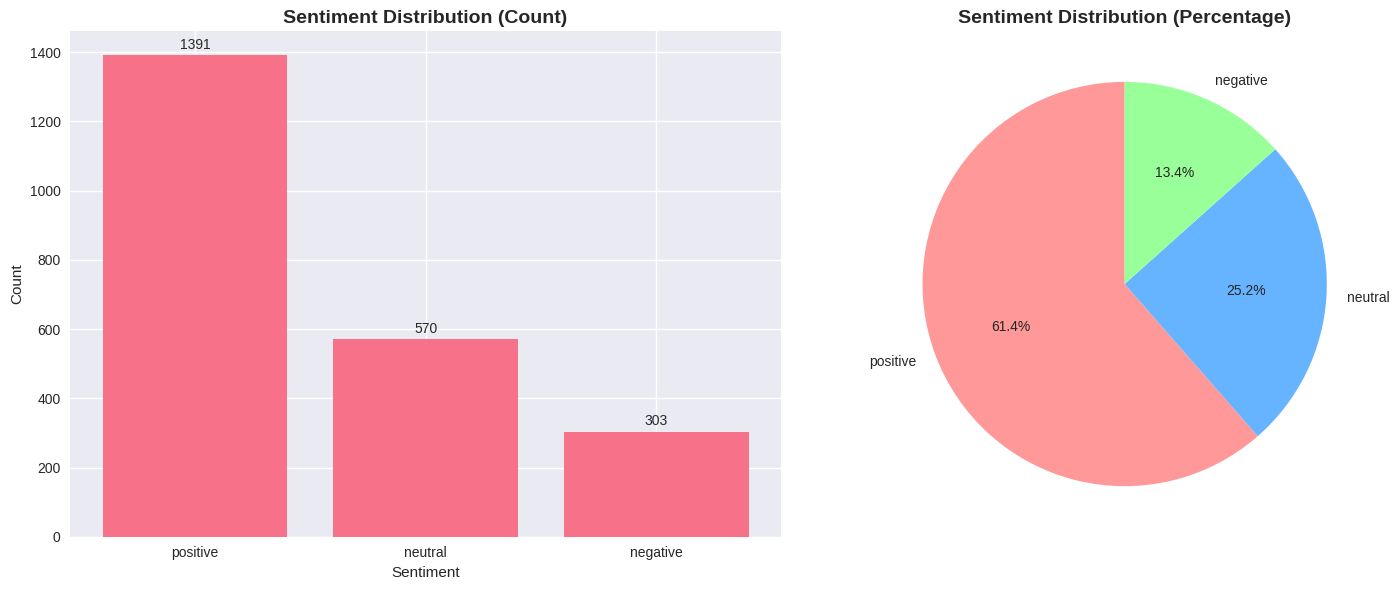

📊 TEXT CHARACTERISTICS ANALYSIS
Overall Statistics:
Average sentence length: 122.0 characters
Average word count: 22.4 words
Average word length: 4.5 characters

Length Distribution by Sentiment:
          char_count        word_count       
                mean    std       mean    std
sentiment                                    
negative      126.38  54.44      24.80  10.28
neutral       129.60  55.39      24.88  10.48
positive      117.87  56.61      20.93   9.68


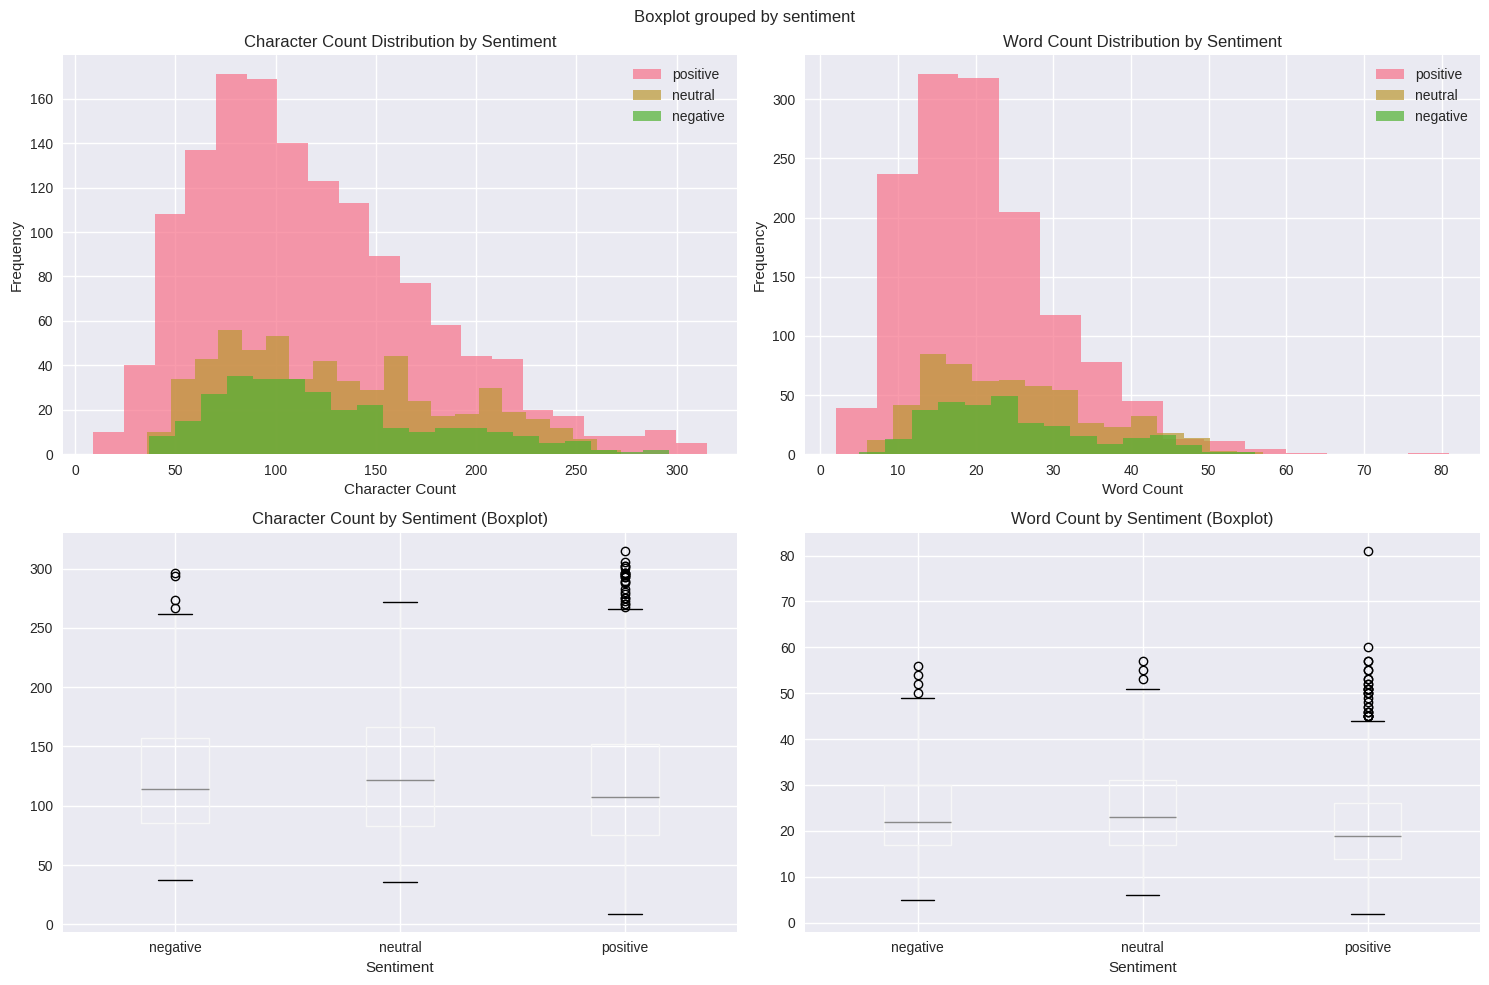

📚 VOCABULARY ANALYSIS
Total words: 47116
Unique words: 6097
Vocabulary richness: 0.129

Most common words:
  the: 2730
  of: 1525
  in: 1386
  and: 1166
  to: 1085
  eur: 756
  a: 735
  for: 542
  from: 517
  s: 475
  mn: 439
  is: 416
  company: 349
  will: 346
  profit: 322
  on: 311
  1: 309
  by: 303
  net: 292
  as: 274

Top words by sentiment:

POSITIVE:
  the: 1810
  of: 908
  and: 884
  in: 676
  to: 453
  is: 386
  a: 384
  s: 299
  for: 292
  will: 291

NEUTRAL:
  the: 581
  in: 443
  to: 426
  eur: 375
  of: 361
  from: 282
  mn: 223
  a: 211
  and: 203
  profit: 172

NEGATIVE:
  the: 339
  in: 267
  of: 256
  eur: 251
  to: 206
  mn: 186
  from: 147
  a: 140
  profit: 122
  net: 84


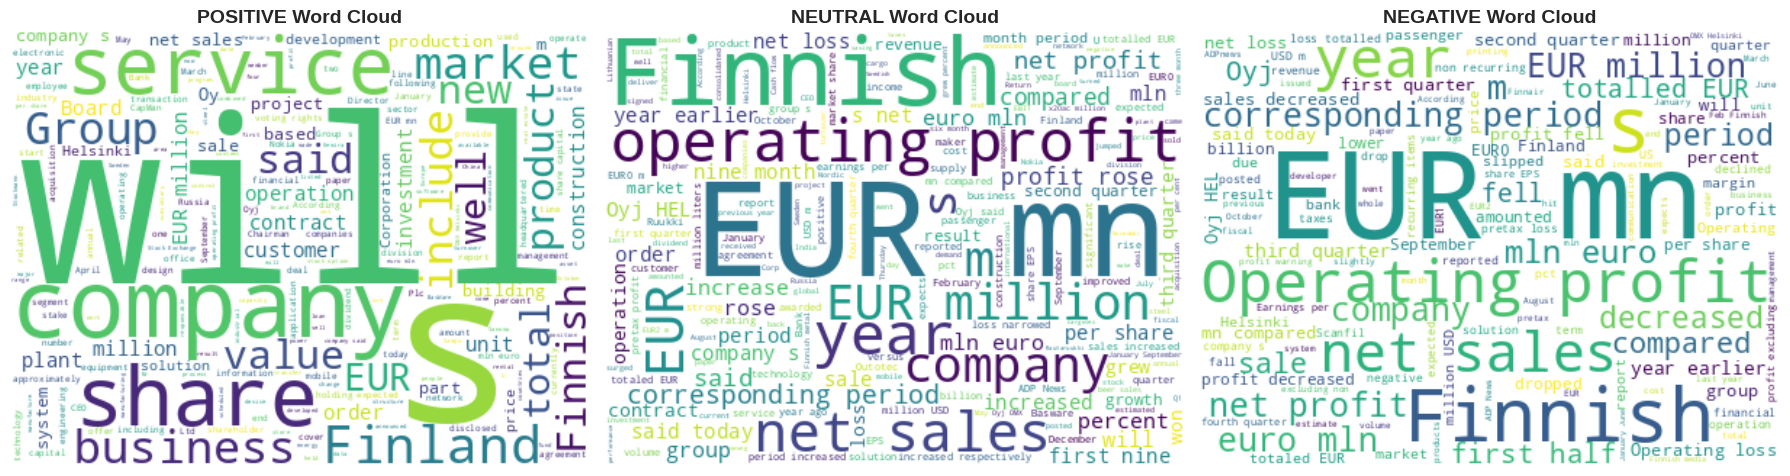

💰 FINANCIAL TERMS ANALYSIS
Financial terms frequency:
  profit: 333
  share: 213
  %: 213
  quarter: 194
  million: 178
  market: 128
  loss: 110
  stock: 65
  percent: 65
  investment: 53
  revenue: 36
  earnings: 33
  growth: 27
  billion: 25
  dividend: 24

Financial terms by sentiment:

POSITIVE:
  share: 137
  market: 84
  million: 65
  %: 60
  quarter: 51
  stock: 50
  investment: 40
  profit: 28

NEUTRAL:
  profit: 179
  %: 95
  quarter: 80
  million: 79
  loss: 55
  share: 49
  percent: 36
  market: 30

NEGATIVE:
  profit: 126
  quarter: 63
  %: 58
  loss: 52
  million: 34
  share: 27
  percent: 15
  market: 14
🔤 TOKENIZATION ANALYSIS
Loading tokenizer: google/gemma-7b-it


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/google/gemma-7b-it.
401 Client Error. (Request ID: Root=1-68346ff3-2c9b01614f3f4adc13071d99;e771f147-0b49-4472-913c-835068b58f40)

Cannot access gated repo for url https://huggingface.co/google/gemma-7b-it/resolve/main/config.json.
Access to model google/gemma-7b-it is restricted. You must have access to it and be authenticated to access it. Please log in.

In [14]:
run_complete_analysis()